In [ ]:
import pandas as pd
import numpy as np
import networkx as nx

In [ ]:


# print unique values for each column

merged_csv = "data/data_css_challenge.csv"

df = pd.read_csv(merged_csv)

for column in df.columns:
    unique_values = df[column].unique()
    print(f"Column: {column}")
    print(f"Unique Values: {unique_values}")
    print(f"Number of Unique Values: {len(unique_values)}")
    print("-" * 40)

/tmp/ipykernel_86710/2878371690.py:7: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(merged_csv)


Column: patient_id
Unique Values: ['bc27a6d71c08' '14337a41ab40' 'dabbff39d904' ... '0f41c63a6bcb'
 '0a2d3cf367ef' '164492116ab7']
Number of Unique Values: 20000
----------------------------------------
Column: age
Unique Values: ['20-30 Jahre' '30-40 Jahre' '0-10 Jahre' '90+ Jahre' '10-20 Jahre'
 '60-70 Jahre' '70-80 Jahre' '40-50 Jahre' '50-60 Jahre' '80-90 Jahre']
Number of Unique Values: 10
----------------------------------------
Column: gender
Unique Values: ['M' 'F']
Number of Unique Values: 2
----------------------------------------
Column: reason_for_treatment
Unique Values: ['Krankheit' 'Unfall' 'Mutterschaft']
Number of Unique Values: 3
----------------------------------------
Column: healthcare_provider_id
Unique Values: ['5f4e30727eb3' '883023cd2176' '9f566ca0c0e4' ... 'ffac2d9e097e'
 '7a92655ab178' '849e6f9b947a']
Number of Unique Values: 22579
----------------------------------------
Column: healthcare_provider_type
Unique Values: ['Zentrumsversorgung, Niveau 2' 'Mikrobi

In [ ]:
# get columns
columns = df.columns
print(f"Columns: {list(columns)}")

Object Columns: ['patient_id', 'age', 'gender', 'reason_for_treatment', 'healthcare_provider_id', 'healthcare_provider_type', 'healthcare_provider_main_group', 'client_id', 'client_type', 'client_main_group', 'start_date', 'end_date', 'tariff', 'tariff_position', 'quantity', 'start_date_num', 'end_date_num']


# Find patients with different journeys

Patient ID Counts:
patient_id
433ca27368c7    7968
d1b1aa55d93e    4963
032f4b1fed2d    4892
4cba78ffe2b5    3675
4619ca22f172    3626
                ... 
8fe40fb1f7ed       1
69b27d25681b       1
11ba4b025d29       1
2b3da3d2de66       1
164492116ab7       1
Name: count, Length: 20000, dtype: int64


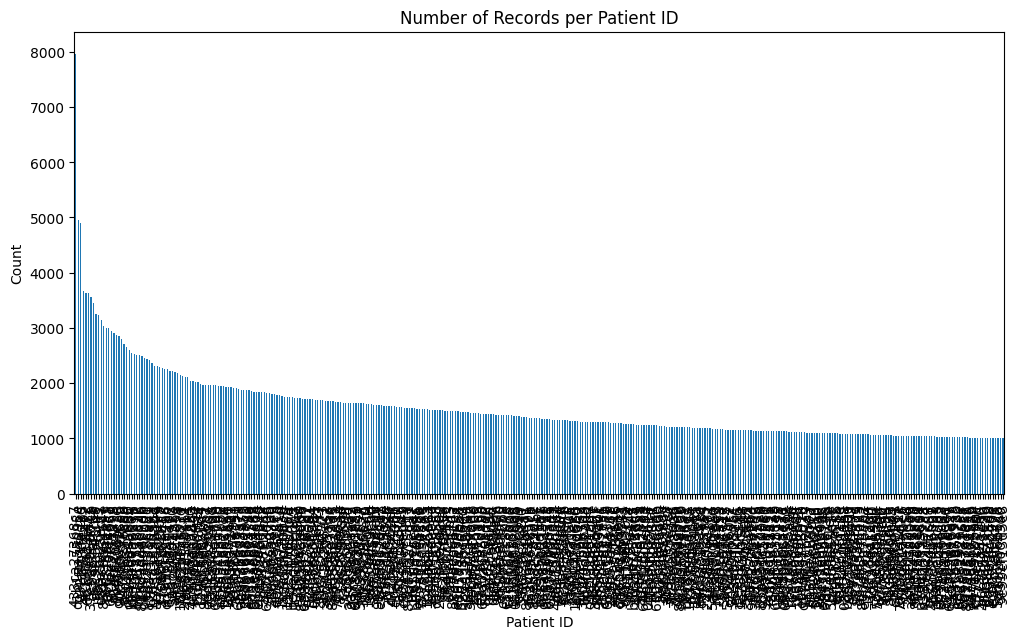

In [6]:
# count by buckets of 100 how many time each patient_id appears in the dataframe
patient_counts = df['patient_id'].value_counts()

print("Patient ID Counts:")
print(patient_counts)


# filter put if patient id only appears once
patient_counts = patient_counts[patient_counts > 1000]

# make it a bar chart
import matplotlib.pyplot as plt
patient_counts.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Patient ID')
plt.ylabel('Count')
plt.title('Number of Records per Patient ID')
plt.show()

In [8]:
# get rows where patient_id == 433ca27368c7
# and print start_date and end_date
patient_journey = df[df['patient_id'] == '433ca27368c7']

print(patient_journey[['start_date', 'end_date', 'reason_for_treatment']])

         start_date    end_date reason_for_treatment
787      2024-01-21  2024-01-21            Krankheit
830      2023-01-30  2023-01-30            Krankheit
978      2023-11-11         NaN            Krankheit
1518     2023-04-09  2023-04-09            Krankheit
2350     2023-09-16  2023-09-16            Krankheit
...             ...         ...                  ...
3967745  2024-03-22  2024-03-22            Krankheit
3967972  2023-08-06  2023-08-06            Krankheit
3968278  2023-09-02  2023-09-02            Krankheit
3969044  2023-09-10  2023-09-10            Krankheit
3969482  2023-01-24  2023-01-24            Krankheit

[7968 rows x 3 columns]


# Investigate date range

In [11]:
# get first date and last date in the dataframe where date is in "YYYY-MM-DD" format

df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
min_start_date = df['start_date'].min()
max_end_date = df['end_date'].max()

print(f"Date Range: {min_start_date} to {max_end_date}")

Date Range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00


In [12]:
# encode each date as a number of days since the min_start_date

df['start_date_num'] = (df['start_date'] - min_start_date).dt.days
df['end_date_num'] = (df['end_date'] - min_start_date).dt.days
print(df[['start_date', 'start_date_num', 'end_date', 'end_date_num']].head())

  start_date  start_date_num   end_date  end_date_num
0 2023-05-23             142        NaT           NaN
1 2023-12-06             339 2023-12-06         339.0
2 2024-01-03             367        NaT           NaN
3 2024-09-29             637 2024-09-29         637.0
4 2023-02-16              46 2023-02-16          46.0


# Providers:

- understand links between providers

In [ ]:
# count unique providers

healthcare_providers_ids = df['healthcare_provider_id'].nunique()
client_ids = df['client_id'].nunique()

print(f"Unique Healthcare Providers: {healthcare_providers_ids}")
print(f"Unique Clients: {client_ids}")

Unique Healthcare Providers: 22579
Unique Clients: 14843


     healthcare_provider_id     client_id  counts
664            0295eb1d5bb3  883023cd2176    1165
798            0380d17bb7e8  842e5783751e    1433
910            03f986404ca0  e32c9a0aa488    1744
2435           0a119182cef2  725601c6e924    1201
2441           0a119182cef2  e56cca93021e    1176
Number of unique links: 70


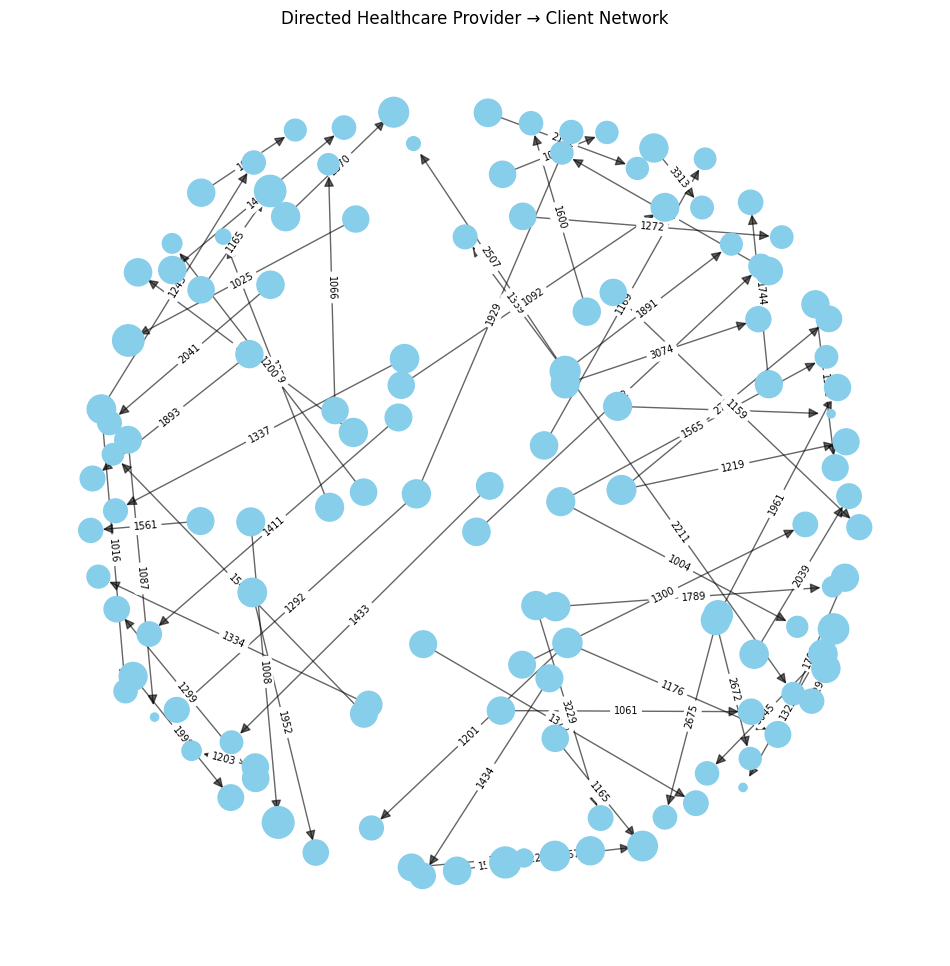

In [ ]:
#  count how many times healthcare_provider_id show up
provider_counts = df['healthcare_provider_id'].value_counts()

# for each row consider the healthcare_provider_id and client_id as a link
# and count how many times each link appears in the dataframe

links = df.groupby(['healthcare_provider_id', 'client_id']).size().reset_index(name='counts')

# mask out links that apper less than 10 times
links = links[links['counts'] >= 1000]

# mask out links between the same healthcare_provider_id and client_id
links = links[links['healthcare_provider_id'] != links['client_id']]

print(links.head())
print(f"Number of unique links: {len(links)}")

# draw each healthcare_provider_id/client_id as a node, link has weight of counts, node size is provider_counts


# create a directed graph
G = nx.DiGraph()

# add nodes with rescaled sizes (log scale)
all_nodes = set(links['healthcare_provider_id']).union(set(links['client_id']))
for node in all_nodes:
    count = provider_counts.get(node, 1)
    size = np.log1p(count) * 50
    G.add_node(node, size=size)

# add edges (directed from provider -> client) with counts as attribute
for _, row in links.iterrows():
    G.add_edge(row['healthcare_provider_id'], row['client_id'], count=row['counts'])

# plotting
node_sizes = [G.nodes[n]['size'] for n in G.nodes]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)

# draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')

# draw directed edges with arrows
nx.draw_networkx_edges(G, pos, width=1, alpha=0.6, arrows=True, arrowstyle='-|>', arrowsize=15)

# draw node labels
# nx.draw_networkx_labels(G, pos, font_size=8)

# draw edge labels
edge_labels = nx.get_edge_attributes(G, 'count')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title("Directed Healthcare Provider → Client Network")
plt.axis('off')
plt.show()

# Link provider types

In [43]:
healthcare_providers_type = df['healthcare_provider_type'].nunique()
client_type = df['client_type'].nunique()

print(f"Unique Healthcare Providers Types: {healthcare_providers_type}")
print(f"Unique Client Types: {client_type}")

Unique Healthcare Providers Types: 108
Unique Client Types: 102


In [ ]:
#  count how many times healthcare_provider_id show up
provider_counts = df['healthcare_provider_type'].value_counts()

# for each row consider the healthcare_provider_type and client_type as a link
# and count how many times each link appears in the dataframe

links = df.groupby(['healthcare_provider_type', 'client_type']).size().reset_index(name='counts')

# mask out links that apper less than 10 times
links = links[links['counts'] >= 1000]

# mask out links between the same healthcare_provider_type and client_type
links = links[links['healthcare_provider_type'] != links['client_type']]

print(links.head())
print(f"Number of unique links: {len(links)}")

# draw each healthcare_provider_type/client_type as a node, link has weight of counts, node size is provider_counts


# create a directed graph
G = nx.DiGraph()

# add nodes with rescaled sizes (log scale)
all_nodes = set(links['healthcare_provider_type']).union(set(links['client_type']))
for node in all_nodes:
    count = provider_counts.get(node, 1)
    size = np.log1p(count) * 50
    G.add_node(node, size=size)

# add edges (directed from provider -> client) with counts as attribute
for _, row in links.iterrows():
    G.add_edge(row['healthcare_provider_type'], row['client_type'], count=row['counts'])

# plotting
node_sizes = [G.nodes[n]['size'] for n in G.nodes]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)

# draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')

# draw directed edges with arrows
nx.draw_networkx_edges(G, pos, width=1, alpha=0.6, arrows=True, arrowstyle='-|>', arrowsize=15)

# draw node labels
# nx.draw_networkx_labels(G, pos, font_size=8)

# draw edge labels
edge_labels = nx.get_edge_attributes(G, 'count')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title("Directed Healthcare Provider → Client Network")
plt.axis('off')
plt.show()

# Unique tariffs & tariff_position

In [41]:
# cast tariffs and tariff_position to floats
df['tariff'] = pd.to_numeric(df['tariff'], errors='coerce')
df['tariff_position'] = pd.to_numeric(df['tariff_position'], errors='coerce')

# unique tariffs & tariff_position jointly
unique_tariffs_and_position = df[['tariff', 'tariff_position']].drop_duplicates()
print(f"Unique Tariff and Tariff Position combinations: {len(unique_tariffs_and_position)}")
print(unique_tariffs_and_position)

# print unique tariffs
unique_tariffs = df['tariff'].unique()
print(f"Unique Tariffs: {len(unique_tariffs)}")
print(unique_tariffs)

Unique Tariff and Tariff Position combinations: 8386
         tariff  tariff_position
0           1.0     3.505100e+01
1           1.0     3.502200e+01
2           1.0     2.500000e-03
3         317.0     4.707100e+03
4         317.0     4.700000e+03
...         ...              ...
3921239   400.0     3.264768e+06
3935305   400.0     1.009345e+06
3938962   400.0     7.785704e+06
3943052   400.0     1.173004e+06
3956677   317.0     3.557000e+03

[8386 rows x 2 columns]
Unique Tariffs: 51
[  1. 317. 960. 400. 570. 532. 581. 405. 312. 340. 406. 324. 452. 940.
 550. 514.  10. 999. 325.   3.  99. 510. 454. 500. 451. 970.   2. 280.
 555. 966. 554. 410.  nan 963.  12. 350. 328.  30.  20. 341. 967. 552.
 515. 551. 930. 407. 513. 511. 322.  31.  11.]
